In [ ]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import scipy
import pdb
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd

In [4]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold

In [5]:
import sys

In [6]:
sys.path.append('/home/akumar/nse/neural_control')

In [26]:
from decoders import lr_decoder
from loaders import load_sabes
from utils import calc_loadings, apply_df_filters

In [8]:
bin_width = [25, 50]
spike_threshold = [0, 100]
data_files = glob('/mnt/Secondary/data/sabes/loco*')
data_files.append('/mnt/Secondary/data/sabes/indy_20160426_01.mat')

In [29]:
decoders = [{'trainlag': 4, 'testlag': 4, 'decoding_window':5},
            {'trainlag': 2, 'testlag': 2, 'decoding_window':5},
            {'trainlag': 6, 'testlag': 6, 'decoding_window':5},
            {'trainlag': 0, 'testlag': 0, 'decoding_window':5}]
loader_args = [{'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'},
               {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'},
               {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':0, 'region':'S1'},
               {'bin_width':100, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':0, 'region':'S1'},
               {'bin_width':100, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'}]

In [28]:
with open('/home/akumar/nse/neural_control/data/loco_decoding_df.dat', 'rb') as f:
    result_list = pickle.load(f)
sabes_df = pd.DataFrame(result_list)

In [30]:
m1df = apply_df_filters(sabes_df, decoder_args=decoders[0], loader_args=loader_args[0])

In [117]:
# Get loadings
DIM = 6

# Try the raw leverage scores instead
loadings_l = []
data_files = np.unique(m1df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(m1df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))


        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}                    
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        # d_['DCA_loadings'] = loadings[2][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

10it [00:00, 84.85it/s]


In [120]:
with open('/home/akumar/nse/neural_control/data/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)

In [121]:
np.unique(indy_df['data_file'].values)

array(['indy_20160426_01.mat', 'indy_20160622_01.mat',
       'indy_20160624_03.mat', 'indy_20160627_01.mat',
       'indy_20160630_01.mat', 'indy_20160915_01.mat',
       'indy_20160921_01.mat', 'indy_20160930_02.mat',
       'indy_20160930_05.mat', 'indy_20161005_06.mat',
       'indy_20161006_02.mat', 'indy_20161007_02.mat',
       'indy_20161011_03.mat', 'indy_20161013_03.mat',
       'indy_20161014_04.mat', 'indy_20161017_02.mat',
       'indy_20161024_03.mat', 'indy_20161025_04.mat',
       'indy_20161026_03.mat', 'indy_20161027_03.mat',
       'indy_20161206_02.mat', 'indy_20161207_02.mat',
       'indy_20161212_02.mat', 'indy_20161220_02.mat',
       'indy_20170123_02.mat', 'indy_20170124_01.mat',
       'indy_20170127_03.mat', 'indy_20170131_02.mat'], dtype=object)

In [123]:
loadings = []
data_file = 'indy_20160426_01.mat'
for dimreduc_method in ['LQGCA', 'PCA']:
    loadings_fold = []
    for fold_idx in range(5):  
        df_ = apply_df_filters(indy_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
        if dimreduc_method == 'LQGCA':
            df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
        V = df_.iloc[0]['coef']
        if dimreduc_method == 'PCA':
            V = V[:, 0:DIM]        
        loadings_fold.append(calc_loadings(V))


    # Average loadings across folds
    loadings.append(np.mean(np.array(loadings_fold), axis=0))

for j in range(loadings[0].size):
    d_ = {}                    
    d_['data_file'] = data_file
    d_['FCCA_loadings'] = loadings[0][j]
    d_['PCA_loadings'] = loadings[1][j]
    # d_['DCA_loadings'] = loadings[2][j]
    d_['nidx'] = j
    loadings_l.append(d_)                

In [124]:
M1_loadings_df = pd.DataFrame(loadings_l)

### Linear regression

In [6]:
# Can also time-resolve this

In [77]:
lrfiles = glob('/home/akumar/nse/neural_control/data/M1S1/*.dat')

In [78]:
rl = []
for f in lrfiles:
    with open(f, 'rb') as f_:
        result = pickle.load(f_)
    rl.append(result)

In [79]:
ldf = pd.DataFrame(rl)
ldf = apply_df_filters(ldf, bin_width=50)

In [80]:
data_files = np.unique(ldf['data_file'].values)

linregress_l = []
regressionlags = np.array([-4, -2, 0, 2, 4])
decoding_window = np.arange(1, 3)

for data_file in data_files:
    df = apply_df_filters(ldf, data_file=data_file)
    for k, rl in enumerate(regressionlags):
        for l, dw in enumerate(decoding_window):
            for r2array in df.iloc[0]['r2']:
                for i in range(r2array.shape[3]):
                    d_ = {}
                    r2 = r2array[l, :, k, i, 0]            
                    nidx = r2array[l, :, k, i, 1]
                    assert(np.all(nidx == nidx[0]))
                    nidx = int(nidx[0])
                    d_ = {}
                    d_['data_file'] = data_file.split('/')[-1]
                    d_['r2'] = r2
                    d_['nidx'] = nidx
                    d_['lag'] = rl
                    d_['window'] = dw
                    linregress_l.append(d_)

In [81]:
linr2df = pd.DataFrame(linregress_l)

5it [00:00, 19.58it/s]/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
10it [00:00, 14.59it/s]


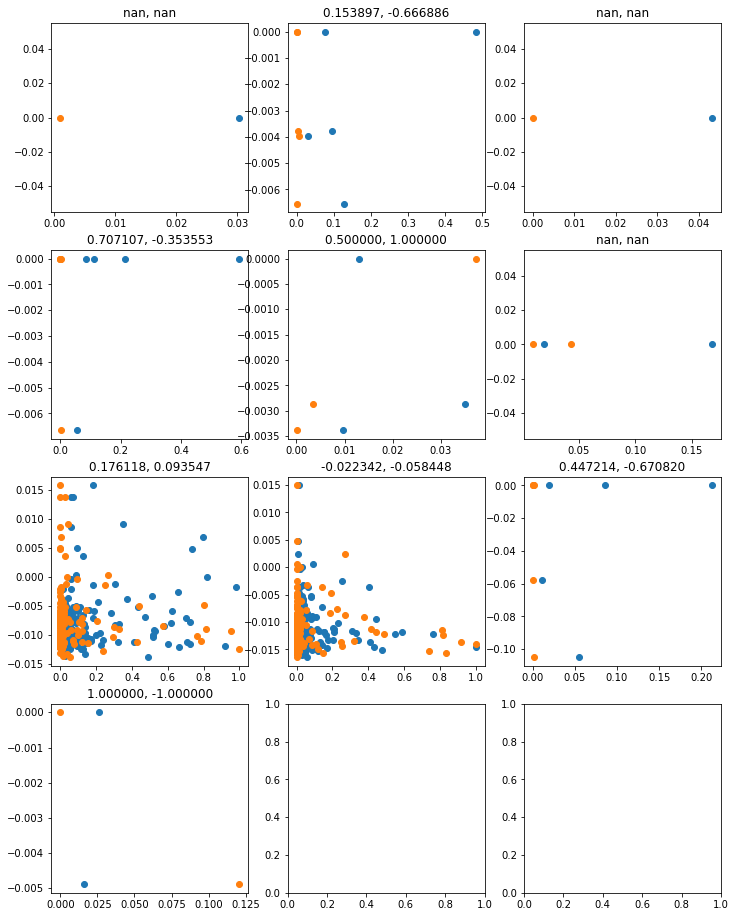

In [101]:
fig, ax = plt.subplots(4, 3, figsize=(12, 16))

dw = 2
lag = 4

data_files = np.unique(m1df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):
    a = ax[np.unravel_index(i, (4, 3))]
    ldf = apply_df_filters(M1_loadings_df, data_file=data_file)
    r2df = apply_df_filters(linr2df, data_file=data_file, window=dw, lag=lag)
    

    neurons = np.unique(ldf['nidx'].values)
    x1 = []
    x2 = []
    y1 = []
    y2 = []
    for nidx in neurons:
        d1 = apply_df_filters(ldf, nidx=nidx)
        assert(d1.shape[0] == 1)
        d2 = apply_df_filters(r2df, nidx=nidx)
        assert(d2.shape[0] == 1)
        

        y_ = np.mean(d2.iloc[0]['r2'])
        x1.append(d1.iloc[0]['FCCA_loadings'])
        x2.append(d1.iloc[0]['PCA_loadings'])
        y1.append(np.mean(d2.iloc[0]['r2']))
        y2.append(np.max(d2.iloc[0]['r2']))

    a.scatter(x1, y1)
    a.scatter(x2, y1)
    a.set_title('%2f, %2f' % (scipy.stats.spearmanr(x1, y1)[0], scipy.stats.spearmanr(x2, y1)[0]))

### CCA

In [10]:
from sklearn.cross_decomposition import CCA
from dca.cov_util import form_lag_matrix
from utils import calc_loadings

In [11]:
bin_width = [50]
spike_threshold = [100]
data_files = glob('/mnt/Secondary/data/sabes/loco*')
data_files.append('/mnt/Secondary/data/sabes/indy_20160426_01.mat')
lags = np.array([4, 2, 0])
windows = np.array([5, 3, 1])

In [12]:
rl = []

for data_file in tqdm(data_files):
    for i, bw in tqdm(enumerate(bin_width)):
        datM1 = load_sabes(data_file, bin_width=bw, region='M1', spike_threshold=0)
        datS1 = load_sabes(data_file, bin_width=bw, region='S1', spike_threshold=0)
        n_M1 = datM1['spike_rates'].shape[-1]
        
        X = datS1['spike_rates'].squeeze()
        Y = datM1['spike_rates'].squeeze()

        loadings = np.zeros((windows.size, lags.size, n_M1, 6))
        loadingssk = np.zeros((windows.size, lags.size, n_M1, 6))
        cc_coef = np.zeros((windows.size, lags.size, 6))

        for i2, lag in enumerate(lags):            
            for j, w in enumerate(windows):      

                # Apply window and lag relative to each other
                if lag != 0:
                    x = X[:-lag, :]
                    y = Y[lag:, :]
                else:
                    x = X
                    y = Y

                if w > 1:
                    x = form_lag_matrix(x, w)
                    y = form_lag_matrix(y, w)

                ccamodel = CCA(n_components=6)
                ccamodel.fit(x, y)

                for k in range(1, 7):
                    loadings[j, i2, :, k - 1] = calc_loadings(ccamodel.y_weights_[:, 0:k], d=w)
                    loadingssk[j, i2, :, k - 1] = calc_loadings(ccamodel.y_loadings_[:, 0:k], d=w)          



        result = {}
        result['data_file'] = data_file
        result['bw'] = bw
        result['loadings'] = loadings
        result['loadings_sk'] = loadingssk

        rl.append(result) 

  0%|          | 0/11 [00:00<?, ?it/s]

96


1it [02:10, 130.70s/it]
  9%|▉         | 1/11 [02:10<21:47, 130.70s/it]

96


/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
1it [04:19, 259.34s/it]
 18%|█▊        | 2/11 [06:30<30:57, 206.37s/it]

96


1it [04:32, 272.87s/it]
 27%|██▋       | 3/11 [11:02<31:33, 236.74s/it]

96


1it [01:47, 107.61s/it]
 36%|███▋      | 4/11 [12:50<21:40, 185.76s/it]

96


1it [04:09, 249.57s/it]
 45%|████▌     | 5/11 [17:00<20:52, 208.77s/it]

96


1it [02:54, 174.58s/it]
 55%|█████▍    | 6/11 [19:54<16:25, 197.15s/it]

96


1it [03:14, 195.00s/it]
 64%|██████▎   | 7/11 [23:09<13:05, 196.44s/it]

96


1it [02:56, 176.43s/it]
 73%|███████▎  | 8/11 [26:06<09:30, 190.07s/it]

96


1it [02:16, 136.29s/it]
 82%|████████▏ | 9/11 [28:22<05:46, 173.26s/it]

96


1it [03:52, 232.97s/it]
 91%|█████████ | 10/11 [32:15<03:11, 191.70s/it]

96


1it [02:03, 123.85s/it]
100%|██████████| 11/11 [34:19<00:00, 187.20s/it]


In [14]:
import pickle

In [15]:
# with open('cca_tmp.dat', 'wb') as f:
#     f.write(pickle.dumps(rl))

In [103]:
with open('cca_tmp.dat', 'rb') as f:
    rl = pickle.load(f)

In [104]:
cca_df = pd.DataFrame(rl)

11it [00:00, 15.17it/s]


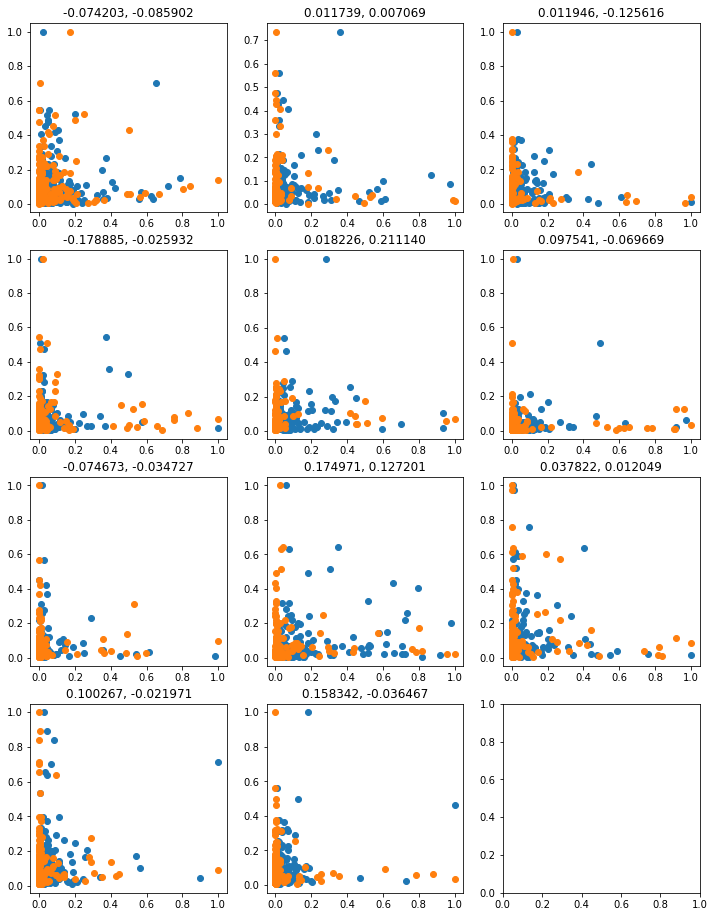

In [129]:
fig, ax = plt.subplots(4, 3, figsize=(12, 16))

# lags = np.array([4, 2, 0])
# windows = np.array([5, 3, 1])


widx = 2
lagidx = 
dimidx = -1

data_files = np.unique(M1_loadings_df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):
    a = ax[np.unravel_index(i, (4, 3))]
    ldf = apply_df_filters(M1_loadings_df, data_file=data_file)
    cdf = apply_df_filters(cca_df, data_file=data_file)
    
    neurons = np.unique(ldf['nidx'].values)
    x1 = []
    x2 = []
    y1 = []
    y2 = []
    for nidx in neurons:
        d1 = apply_df_filters(ldf, nidx=nidx)
        assert(d1.shape[0] == 1)
        
        x1.append(d1.iloc[0]['FCCA_loadings'])
        x2.append(d1.iloc[0]['PCA_loadings'])
        
        y1.append(cdf.iloc[0]['loadings'][widx, lagidx, nidx, dimidx])
        y2.append(np.max(cdf.iloc[0]['loadings_sk'][widx, lagidx, nidx, dimidx]))

    a.scatter(x1, y1)
    a.scatter(x2, y1)
    a.set_title('%2f, %2f' % (scipy.stats.spearmanr(x1, y1)[0], scipy.stats.spearmanr(x2, y1)[0]))

### DI calculation

In [ ]:
T = [2, 3, 4, 5]

In [ ]:
DIall = []
for data_file in data_files:
    DI = []
    for i, bw in enumerate(bin_width):
        datM1 = load_sabes(data_file, bin_width=bw, region='M1')
        datS1 = load_sabes(data_file, bin_width=bw, region='S1')
        di = np.zeros((decoding_window.size, 5, regressionslags.size, datM1.shape[-1]))
        for i2, dw in enumerate(decoding_window):            
            X = datS1['spike_rates'].squeeze()
            Y = datM1['spike_rates'].squeeze()
            for f, (train_idxs, test_idxs) in KFold(n_splits=5).split(X, shuffle=False):
                for j, rl in enuemrate(regressionlags):      
                    for k in range(datM1.shape[-1]):
                        xtrain = X[train_idxs] 
                        xtest = X[test_idxs]
                        ytrain = Y[train_idxs, k][:, np.newaxis]
                        ytest = Y[test_idxs, k][:, np.newaxis]

                        r2_, _ = lr_decoder(xtest, xtrain, ytest, ytrain, rl, rl, decoding_window=dw, include_velocity=False, include_acc=False)
                        r2[i2, f, j, k]
        R2.append(r2[np.newaxis, ...])
    R2 = np.concatenate(R2)
    R2all.append(R2)

In [ ]:
DIall = []

### DI projection